In [1]:
import sys
sys.path.append("../")
from lib.metadata import MetadataListSiena
from lib.signals import EegProcessorSiena
from lib.spectral import FourierAnalysis
from lib.filters import FilterBank
from lib.visuals import plot_eeg_windows, plot_eeg_spectrum

/var/tmp/venv-project-1/lib/python3.11/site-packages/numpy/_core/getlimits.py:551: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


#### * Scales the EEG signal
#### * Select a subset of the channels

Extracting EDF parameters from /mnt/c/Users/tobit/Downloads/eeg_datasets/siena/PN00/PN00-1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/mnt/c/Users/tobit/Documents/Doctorado/Initiative1_epic1/Project/code/notebooks/../lib/signals.py:135: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  data = mne.io.read_raw_edf(filename)
/mnt/c/Users/tobit/Documents/Doctorado/Initiative1_epic1/Project/code/notebooks/../lib/signals.py:135: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  data = mne.io.read_raw_edf(filename)
/mnt/c/Users/tobit/Documents/Doctorado/Initiative1_epic1/Project/code/notebooks/../lib/signals.py:135: RuntimeWarning: Highpass cutoff frequency 15.91549 is greater than lowpass cutoff frequency 15.0, setting values to 0 and Nyquist.
  data = mne.io.read_raw_edf(filename)


2025-02-13 00:36:16,657 - root - INFO - Recording contains channels = ['EEG Fp1', 'EEG F3', 'EEG C3', 'EEG P3', 'EEG O1', 'EEG F7', 'EEG T3', 'EEG T5', 'EEG Fc1', 'EEG Fc5', 'EEG Cp1', 'EEG Cp5', 'EEG F9', 'EEG Fz', 'EEG Cz', 'EEG Pz', 'EEG Fp2', 'EEG F4', 'EEG C4', 'EEG P4', 'EEG O2', 'EEG F8', 'EEG T4', 'EEG T6', 'EEG Fc2', 'EEG Fc6', 'EEG Cp2', 'EEG Cp6', 'EEG F10', 'EKG EKG', 'SPO2', 'HR', '1', '2', 'MK']


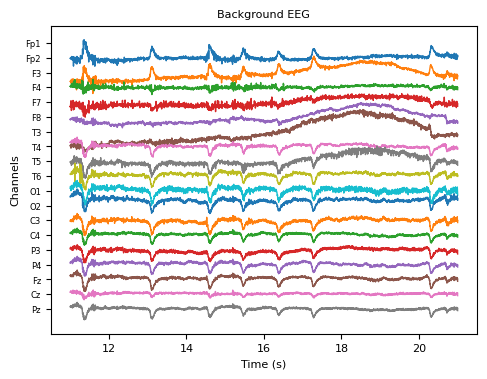

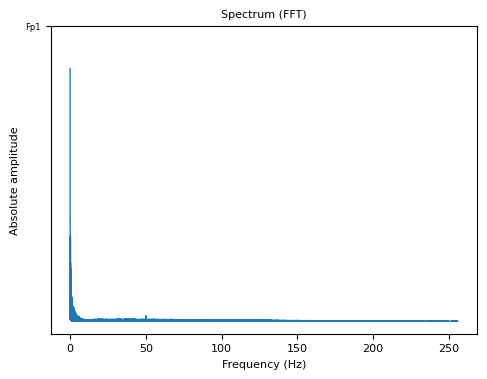

In [2]:
PATIENT = "PN00"
FILENAME = "PN00-1.edf"
PERIOD = [11, 21]

###########################################################
metadata = MetadataListSiena()
current_metadata = metadata.get(PATIENT, FILENAME)

###########################################################
processor = EegProcessorSiena(current_metadata["full_file"])
processor.scale()
processor.select_channels()

###########################################################
fourier = FourierAnalysis(processor.sampling_frequency)
frequency_range, spectral_components = fourier.run_fast_fourier_transform(processor._data)

###########################################################
plot_eeg_windows(processor._data, current_metadata, processor.selected_channels, processor.sampling_frequency, PERIOD)

###########################################################
plot_eeg_spectrum(frequency_range, spectral_components, processor.selected_channels, subset_channels=[0])

### * Resample the EEG to 256Hz

2025-02-13 00:36:26,963 - root - INFO - Dowsampling factor is = 2


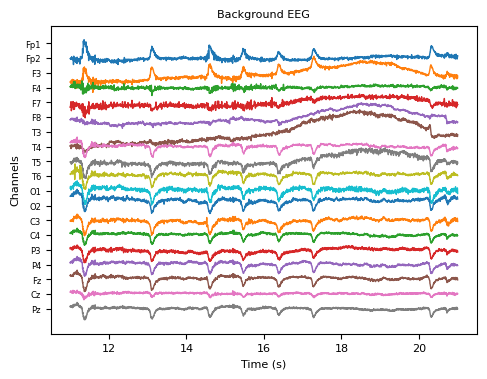

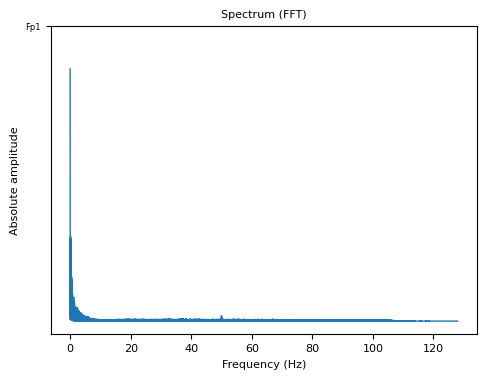

In [3]:
###########################################################
processor.resample()

###########################################################
fourier = FourierAnalysis(processor.sampling_frequency)
frequency_range, spectral_components = fourier.run_fast_fourier_transform(processor._data)

###########################################################
plot_eeg_windows(processor._data, current_metadata, processor.selected_channels, processor.sampling_frequency, PERIOD)

###########################################################
plot_eeg_spectrum(frequency_range, spectral_components, processor.selected_channels, subset_channels=[0])

### * Remove the drift noise

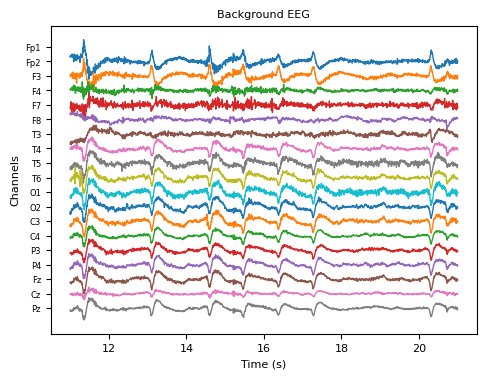

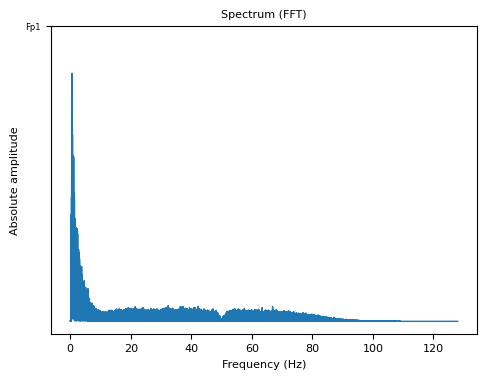

In [4]:
###########################################################
processor.filter_bank = FilterBank(0)
processor.remove_drift()
processor.remove_hfo()
processor.remove_power_noise()

###########################################################
fourier = FourierAnalysis(processor.sampling_frequency)
frequency_range, spectral_components = fourier.run_fast_fourier_transform(processor._data)

###########################################################
plot_eeg_windows(processor._data, current_metadata, processor.selected_channels, processor.sampling_frequency, PERIOD)

###########################################################
plot_eeg_spectrum(frequency_range, spectral_components, processor.selected_channels, subset_channels=[0])